# Referring Expressions for Categories

This notebook explores a bit about how the COCO categories are described by the referring expressions.

In [1]:
# imports

from itertools import chain, permutations, combinations
from collections import Counter
import configparser
import os
from textwrap import fill
import scipy
import sys
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display
import collections as col


pd.set_option('max_colwidth', 250)

In [2]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [3]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = [#'saiapr_bbdf', 
            #'saiapr_refdf',
            'mscoco_bbdf', 
            'cococapdf', 
            'mscoco_catsdf',
            'refcoco_refdf', 
            #'refcocoplus_refdf', 
            #'grex_refdf',
            #'vgregdf', 
            #'vgimgdf', 
            #'vgobjdf' 
            #'vgreldf',
            #'vgattdf', 
            #'vgvqadf', 
            #'vgpardf', 
            #'flickr_bbdf', 
            #'flickr_capdf', 
            #'flickr_objdf'
            ]
df = load_dfs(preproc_path, df_names)

# a derived DF, containing only those region descriptions which I was able to resolve
#df['vgpregdf'] = df['vgregdf'][df['vgregdf']['pphrase'].notnull() & 
#                               (df['vgregdf']['pphrase'] != '')]

# easier to look up:
#cococat = dict(zip(df['mscoco_catsdf'].index, df['mscoco_catsdf']['cat'].values))

In [4]:
def category_lookup(i_corpus, image_id, region_id):
    this_df = df['mscoco_bbdf']
    cat = query_by_id(this_df, 
                      (i_corpus, image_id, region_id),
                     column='cat')[0]
    return cat

def cat_name(cat_num):
    this_df = df['mscoco_catsdf']
    row = this_df.loc[cat_num]
    cat = row['cat']
    super_cat = row['supercat']
    return cat, super_cat
    #return row

First, we look at the nouns describing the categories. We take the tagged expressions and assume that the first word tagged with 'NN' is the head noun.

In [5]:
cat_nouns_dict = dict()

def first_noun(l):
    just_nouns = [w[0] for w in l if w[1] == 'NN']
    if just_nouns == []:
        return None
    return just_nouns[0]

samples = df['mscoco_bbdf'].sample(20000)
for i, row in samples.iterrows():
    triple = (row['i_corpus'],
              row['image_id'],
              row['region_id'])
    cat = cat_name(row['cat'])
    ref_exps = query_by_id(df['refcoco_refdf'], triple)['tagged']
    if ref_exps.empty:
        continue
    ref_nouns = [first_noun(exp) for exp in ref_exps 
                 if first_noun(exp) is not None]

    for noun in ref_nouns:
        if cat in cat_nouns_dict:
            cat_nouns_dict[cat][noun] += 1
        else:
            cat_nouns_dict[cat] = col.defaultdict(int)
            cat_nouns_dict[cat][noun] += 1

In [6]:
cat_nouns_dict

{('train', 'vehicle'): defaultdict(int,
             {'train': 23,
              'left': 3,
              'carriage': 1,
              'bottom': 1,
              'yellow': 2,
              'yelo': 1,
              'middle': 1,
              'rightmost': 1,
              'green': 1,
              'gray': 1,
              'number': 1,
              'bus': 2,
              'wall': 2,
              'front': 1}),
 ('person', 'person'): defaultdict(int,
             {'person': 217,
              'lady': 69,
              'guy': 285,
              'child': 23,
              'toddler': 1,
              'kid': 68,
              'girl': 143,
              'shirt': 114,
              'woman': 204,
              'right': 27,
              'blue': 11,
              'skier': 14,
              'batter': 50,
              'man': 340,
              'officer': 2,
              'left': 20,
              'gamer': 1,
              'second': 4,
              'bottom': 16,
              'row': 4,
           

In order to identify regions with multiple likely names, we remove regions where one word makes up 50% of the nouns.

In [7]:
mult_names = dict()
for cat, subdict in cat_nouns_dict.items():
    total = sum(subdict.values())
    max_percentage = 0
    for key in subdict:
        perc = subdict[key] / total
        if perc > max_percentage:
            max_percentage = perc
    if max_percentage < 0.5:
        #print(max_percentage)
        mult_names[cat] = subdict
    else:
        print(cat)

('train', 'vehicle')
('zebra', 'animal')
('chair', 'furniture')
('elephant', 'animal')
('book', 'indoor')
('car', 'vehicle')
('bed', 'furniture')
('airplane', 'vehicle')
('clock', 'indoor')
('umbrella', 'accessory')
('cat', 'animal')
('cow', 'animal')
('giraffe', 'animal')
('horse', 'animal')
('vase', 'indoor')
('boat', 'vehicle')
('microwave', 'appliance')
('spoon', 'kitchen')
('orange', 'food')
('bus', 'vehicle')
('surfboard', 'sports')
('dog', 'animal')
('bottle', 'kitchen')
('toothbrush', 'indoor')
('bench', 'outdoor')
('bicycle', 'vehicle')
('sink', 'appliance')
('tie', 'accessory')
('kite', 'sports')
('bear', 'animal')
('keyboard', 'electronic')
('snowboard', 'sports')
('cell phone', 'electronic')
('backpack', 'accessory')
('remote', 'electronic')
('parking meter', 'outdoor')


In [8]:
mult_names

{('person', 'person'): defaultdict(int,
             {'person': 217,
              'lady': 69,
              'guy': 285,
              'child': 23,
              'toddler': 1,
              'kid': 68,
              'girl': 143,
              'shirt': 114,
              'woman': 204,
              'right': 27,
              'blue': 11,
              'skier': 14,
              'batter': 50,
              'man': 340,
              'officer': 2,
              'left': 20,
              'gamer': 1,
              'second': 4,
              'bottom': 16,
              'row': 4,
              'rightmost': 1,
              'veyr': 1,
              'arm': 25,
              'boy': 62,
              'dude': 21,
              'tan': 2,
              'pink': 19,
              'fence': 1,
              'manin': 1,
              'player': 33,
              'nerd': 1,
              'skiing': 1,
              'jacket': 11,
              'blurry': 9,
              'purple': 5,
              'center': 11,


For a better overview: remove entries with only one or two occurences.

In [9]:
remove_rare_words = dict()
for cat, subdict in mult_names.items():
    new_subdict = col.defaultdict(int)
    for word, count in subdict.items():
        if count > 2:
            new_subdict[word] = count
    remove_rare_words[cat] = new_subdict

In [10]:
remove_rare_words

{('person', 'person'): defaultdict(int,
             {'person': 217,
              'lady': 69,
              'guy': 285,
              'child': 23,
              'kid': 68,
              'girl': 143,
              'shirt': 114,
              'woman': 204,
              'right': 27,
              'blue': 11,
              'skier': 14,
              'batter': 50,
              'man': 340,
              'left': 20,
              'second': 4,
              'bottom': 16,
              'row': 4,
              'arm': 25,
              'boy': 62,
              'dude': 21,
              'pink': 19,
              'player': 33,
              'jacket': 11,
              'blurry': 9,
              'purple': 5,
              'center': 11,
              'blond': 4,
              'background': 3,
              'umpire': 9,
              'bride': 4,
              'front': 13,
              'vest': 3,
              'middle': 9,
              'groom': 6,
              'hand': 18,
              'corner': 

Different approach: only take the five most common words.

In [11]:
most_common = dict()
for cat, subdict in mult_names.items():
    new_subdict = col.defaultdict(int)
    for word, count in subdict.items():
        if len(new_subdict) < 5:
            new_subdict[word] = count
        else:
            smallest = None
            for k,v in new_subdict.items():
                if smallest is None:
                    smallest = k
                else:
                    if new_subdict[smallest] > v:
                        smallest = k
            if new_subdict[smallest] < count:
                del new_subdict[smallest]
                new_subdict[word] = count
    most_common[cat] = new_subdict

In [12]:
most_common

{('person', 'person'): defaultdict(int,
             {'person': 217,
              'guy': 285,
              'girl': 143,
              'woman': 204,
              'man': 340}),
 ('sandwich', 'food'): defaultdict(int,
             {'left': 3, 'food': 7, 'sandwich': 6, 'half': 4, 'right': 4}),
 ('tv', 'electronic'): defaultdict(int,
             {'monitor': 6,
              'screen': 7,
              'computer': 3,
              'universal': 1,
              'tablet': 3}),
 ('broccoli', 'food'): defaultdict(int,
             {'broccoli': 11,
              'bottom': 6,
              'broc': 4,
              'piece': 5,
              'brocolli': 4}),
 ('toilet', 'furniture'): defaultdict(int,
             {'dish': 1, 'toilet': 13, 'second': 1, 'right': 2, 'bottom': 3}),
 ('banana', 'food'): defaultdict(int,
             {'bunch': 10,
              'bottom': 11,
              'bannana': 2,
              'banana': 24,
              'row': 4}),
 ('motorcycle', 'vehicle'): defaultdict(int,
  

Get the numbers of different words for each category:

In [13]:
cat_sum_list = []
for cat in cat_nouns_dict:
    subdict = cat_nouns_dict[cat]
    cat_sum = len(subdict.values())
    cat_sum_list.append((cat, cat_sum))

cat_sum_list = sorted(cat_sum_list, key=(lambda x: x[1]), reverse=True)

for cat, cat_sum in cat_sum_list:
    print(cat, cat_sum)

('person', 'person') 225
('bowl', 'kitchen') 44
('couch', 'furniture') 32
('giraffe', 'animal') 28
('cake', 'food') 26
('sandwich', 'food') 25
('umbrella', 'accessory') 24
('sheep', 'animal') 23
('banana', 'food') 22
('cow', 'animal') 22
('teddy bear', 'indoor') 22
('car', 'vehicle') 21
('cup', 'kitchen') 21
('dining table', 'furniture') 20
('chair', 'furniture') 19
('elephant', 'animal') 19
('donut', 'food') 19
('zebra', 'animal') 18
('motorcycle', 'vehicle') 18
('bus', 'vehicle') 18
('broccoli', 'food') 17
('potted plant', 'furniture') 16
('apple', 'food') 15
('train', 'vehicle') 14
('vase', 'indoor') 14
('boat', 'vehicle') 14
('pizza', 'food') 14
('suitcase', 'accessory') 14
('toilet', 'furniture') 12
('wine glass', 'kitchen') 11
('refrigerator', 'appliance') 11
('horse', 'animal') 10
('truck', 'vehicle') 10
('orange', 'food') 10
('bird', 'animal') 10
('bear', 'animal') 10
('traffic light', 'outdoor') 9
('cat', 'animal') 8
('hot dog', 'food') 8
('bicycle', 'vehicle') 8
('laptop', 'e

It is possible that this is just an effect of some categories occuring more often than other categories, so that these categories have more opportunities to be labeled differently. In order to find out about this, we plot the numbers and order the categories according to how often they occur.

Display the number of different words for each category. Categories are ordered according to the number of their occurrences.

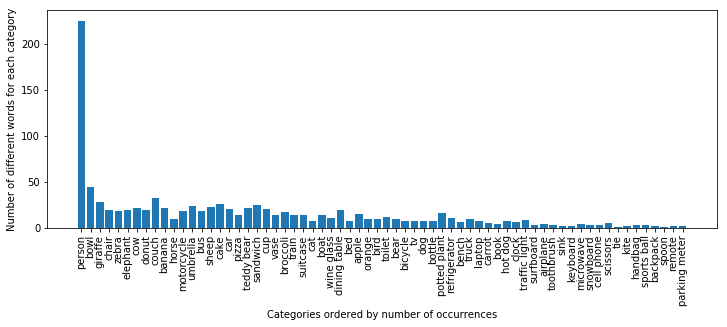

In [14]:
def cat_occurrences(cat):
    subdict = cat_nouns_dict[cat]
    cat_occurrences = sum(subdict.values())
    return cat_occurrences

diff_word_list = sorted(cat_sum_list, 
                        key=(lambda x: cat_occurrences(x[0])),
                        reverse=True)

fig, ax = plt.subplots()
index = [t[0][0] for t in diff_word_list]
values = [t[1] for t in diff_word_list]
rects = ax.bar(index, values)
plt.xticks(range(len(diff_word_list)), index, rotation='vertical')
ax.set_xlabel('Categories ordered by number of occurrences')
ax.set_ylabel('Number of different words for each category')
fig.set_size_inches((12,4))
plt.show()

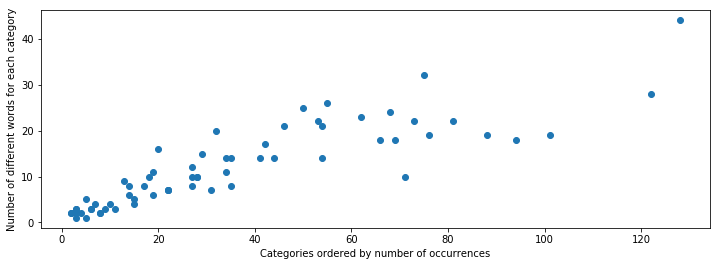

In [23]:
fig, ax = plt.subplots()
index = [cat_occurrences(t[0]) for t in diff_word_list][1:]
values = [t[1] for t in diff_word_list][1:]
rects = ax.scatter(index, values)
#plt.xticks(range(len(diff_word_list)), index, rotation='vertical')
ax.set_xlabel('Categories ordered by number of occurrences')
ax.set_ylabel('Number of different words for each category')
fig.set_size_inches((12,4))
plt.show()

It seems like categories that occur more often also tend to have a higher number of referring words. That might be caused simply by the number of possibilities or maybe there is some correlation with concepts that are more important also occurring more often and having more possible words to describe them.

We also looked at the lengths of the referring expressions to get some idea if maybe objects of some categories are "easier" to point out. 

In [24]:
cat_ref_dict = dict()

samples = df['mscoco_bbdf'].sample(20000)
for i, row in samples.iterrows():
    triple = (row['i_corpus'],
              row['image_id'],
              row['region_id'])
    cat = cat_name(row['cat'])
    ref_exps = query_by_id(df['refcoco_refdf'], triple)['tagged']
    if ref_exps.empty:
        continue
    if cat not in cat_ref_dict:
        cat_ref_dict[cat] = []
    for exp in ref_exps:
        cat_ref_dict[cat].append(exp)

In [31]:
cat_lengths = dict()

for cat in cat_ref_dict:
    length_list = [len(exp) for exp in cat_ref_dict[cat]]
    avg_len = round(np.mean(length_list), 3)
    std_len = round(np.std(length_list), 3)
    cat_lengths[cat] = (avg_len, std_len)

In [32]:
sorted(cat_lengths.items(), key=(lambda x: x[1][0]), reverse=True)

[(('bench', 'outdoor'), (5.778, 2.439)),
 (('banana', 'food'), (5.103, 2.499)),
 (('broccoli', 'food'), (4.912, 2.705)),
 (('wine glass', 'kitchen'), (4.9, 2.447)),
 (('sheep', 'animal'), (4.609, 2.427)),
 (('backpack', 'accessory'), (4.5, 2.55)),
 (('potted plant', 'furniture'), (4.429, 2.216)),
 (('skateboard', 'sports'), (4.333, 2.055)),
 (('keyboard', 'electronic'), (4.2, 2.135)),
 (('dining table', 'furniture'), (4.182, 2.07)),
 (('orange', 'food'), (4.179, 2.531)),
 (('chair', 'furniture'), (4.11, 2.351)),
 (('suitcase', 'accessory'), (4.105, 2.337)),
 (('surfboard', 'sports'), (4.059, 1.552)),
 (('sandwich', 'food'), (4.042, 3.559)),
 (('donut', 'food'), (4.039, 2.105)),
 (('boat', 'vehicle'), (4.021, 2.056)),
 (('traffic light', 'outdoor'), (4.0, 1.871)),
 (('toilet', 'furniture'), (3.909, 2.503)),
 (('bed', 'furniture'), (3.875, 1.816)),
 (('bottle', 'kitchen'), (3.833, 2.339)),
 (('book', 'indoor'), (3.778, 2.07)),
 (('teddy bear', 'indoor'), (3.776, 2.205)),
 (('couch', 'fur